In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#@author: Kelle Clark, Andrew Florian, Xinyu Xiong
#Created on Tue Feb  4 10:05:49 2020
#CSCI 6040 Project 1 Text Generation
#PHASE 5: Smoothing the Language Models for the Corpus

#Various folders of .txt files were created in the CSCI6040 Team Project 1 folder
#to be used for testing our application during develpment
#/Short Test Data
# has 3 .txt files each about 4KB
#/Med test Data 
# has 2 .txt files one of 119KB (Tragedy of Macbeth) and 6.5MB (big)
#/Grande test Data (the 18-document-gutenburg-copus but with 19? files cleaned using the 
#boilerplate.ipynb -author Andrew Florian and resulting files 
#shared on Canvas in Project 1 discussion forum)
# has 19 .txt files with a total of 11.8MB

In [21]:
#we needed the help of a few packages...import all those at once
import langid
import itertools 
import math
import mmap
import nltk
import numpy
import os
import pandas
import random
import re
import string
import sys
from collections import Counter
from math import log10
from matplotlib.pyplot import yscale, xscale, title, plot
from nltk.tokenize import word_tokenize, sent_tokenize

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM
#from keras.utils import np_utils
#from keras.callbacks import ModelCheckpoint


In [22]:
#**** from phase 1 reading in the tokenized corpus

def tokensByFiles(folderpath):
    textfiles = [f for f in os.listdir(folderpath) if '.txt' in f]
    tokenfilelist =[]
    
    for f in textfiles:
            rawcorpus = []
            substring = ''
            file = open(folderpath+"/"+f,'rt', encoding='utf-8', errors='replace')                                   
            print (f"     Reading from: '{f}' . . .")
            rawcorpus.append(file.read()
                     .replace('. . .','.')
                     .replace('!',' .')  # substitue space period for ! mark to have a simple token to end a sentence 
                     .replace('"',' ')
                     .replace('#',' ')  
                     .replace('$',' ')
                     .replace('%',' ')
                     .replace('&',' ')
                     .replace('\\',' ') 
                     .replace('\' ',' ')  # only remove ' if it has a space before or after meaning it is used as a quote
                     .replace(' \'',' ')  # but leave it in if it is inside a word as a contraction
                     .replace('\- ',' ')  # only remove - if it has a space before or after meaning it is to be left in the 
                     .replace(' \-',' ')  # word e.g. C-A-T
                     .replace('(',' ')
                     .replace('\n', ' ')        
                     .replace(')',' ')
                     .replace('*',' ')
                     .replace('+',' ')
                     .replace(',',' ')
                     .replace('. ',' ')  
                     .replace('/',' ')                 
                     .replace(':',' ')
                     .replace(';',' ')
                     .replace('<',' ')
                     .replace('=',' ')
                     .replace('>',' ')
                     .replace('?',' .')  # substitue space period for ? mark to have a simple token to end a sentence
                     .replace('@',' ')
                     .replace('[',' ')
                     .replace('\\',' ')
                     .replace(']',' ')
                     .replace('^',' ')
                     .replace('_',' ')   #  remove all unwanted punctuation
                     .replace('`',' ')
                     .replace('{',' ')
                     .replace('|',' ')
                     .replace('}',' ')
                     .replace('~',' ')
                     .replace('0',' ')   #  remove all digits
                     .replace('1',' ')
                     .replace('2',' ')
                     .replace('3',' ')
                     .replace('4',' ')
                     .replace('5',' ')                
                     .replace('6',' ')
                     .replace('7',' ')
                     .replace('8',' ')
                     .replace('9',' '))            
            file.close()
            
            substring = substring + rawcorpus[0]
            #print(f"the language of file "+f+" is {nltk.language(substring)}")
            print(f"the estimated language of the file {f} is {langid.classify(substring)}")
            
            #tokens=substring.split()
            tokens = word_tokenize(substring)
            tokens = [w.lower() for w in tokens]
            tokenfilelist.append(tokens)
             
    return tokenfilelist


#we have the different files tokenized, in the variable tokenfilelist
#method below creates one corpus from the string of tokens in each file 
def createOneCorpus(inlist):
    temp = " "
    for i in range(len(inlist)):
        for w in inlist[i]:
            temp = temp + w + " "
    return temp

def printcorpus(instring):
    if len(instring) > 500: 
        print(f"The first & last 50 tokens of this corpus are:\n  {instring[:50]} \t ... {instring[-50:]}\n")
    else:
        print(f"The tokens in the corpus are: \n {instring} \n")

#ngrams returns a dictionary
# enumerate ngrams code copied from Eisentein and CSCI6040 ipynb
# returns the ngram from instring and n
def ngrams(instring, n):
    outset = {}
    for i in range(len(instring) - n + 1):
        g = ' '.join(instring[i:i+n])
        outset.setdefault(g, 0)
        outset[g] += 1
    return outset        

#### modified from phase 2, The team kept both ngrams method and newngram method for computing the 
###unigrams models....
###output of this newngram is a dictionary obj ...

#!!!newngram now returns a dictionary object 
def newngram(toks, n):
    output = {}   
    for i in range(len(toks) - n + 1):
        g = ' '.join(toks[i:i+n])
        output.setdefault(g, 0)
        output[g] += 1
    
   
    return output

In [23]:
#**** from phase 1 reading in the .txt files and creating the tokenized corpus
pathname = 'Test Data/short test data'
##pathname = 'your choice of path here'

#read in the corups file by file
tokenfilelist = tokensByFiles(pathname)
print(tokenfilelist)

tokencorpus = createOneCorpus(tokenfilelist)
printcorpus(tokencorpus)
tokens = tokencorpus.split()

     Reading from: 'Testset1.txt' . . .
the estimated language of the file Testset1.txt is ('en', -112.47618627548218)
     Reading from: 'Testset2.txt' . . .
the estimated language of the file Testset2.txt is ('en', -757.8414204120636)
     Reading from: 'Testset3.txt' . . .
the estimated language of the file Testset3.txt is ('en', -295.17291164398193)
[['the', 'cat', 'named', 'bob', 'is', 'damn', 'good', 'he', 'is', 'the', 'best', 'c-a-t', 'on', 'earth'], ['what', 'do', 'we', 'do', 'if', 'there', 'are', 'hyphens', 'capitols', 'in', 'the', 'middle', 'of', 'a', 'word', 'misspellings', '.', 'do', 'we', 'want', 'to', 'keep', 'track', 'of', 'words', 'at', 'the', 'beginning', 'of', 'sentences', '.', 'our', 'test', 'data', 'need', 'to', 'have', 'enough', 'words', 'that', 'have', 'high', 'frequency', 'what', 'do', 'we', 'do', 'with', 'words', 'like', '.exe', 'or', 'http', 'www.weirdo.com', 'and', 'and', '.'], ['this', 'damn', 'cat', 'whose', 'name', 'is', 'bob', 'is', 'no', 'good', 'my', 'do

The sum of all the probabiities of unigrams needs to be 1 and it is 1.0000000000000009

Number of rows in Unigram Prob. Model :  63
           prob.
the     0.052632
cat     0.021053
named   0.010526
bob     0.021053
is      0.052632
...          ...
cats    0.010526
should  0.010526
not     0.010526
exist   0.010526
dogs    0.010526

[63 rows x 1 columns]
the unigram of greatest freq is: do 



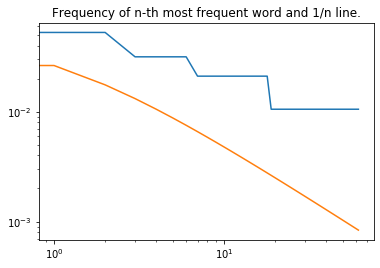

In [33]:
#**** from phase 2 creating the unigram language models using ngrams:
#unigram prob. model using prob(x) = (frequency of x in corpus)/(total in corpus)

def createUnigramModel(instring):
    n = 1
    outset = word_tokenize(instring)
    totalpossible = len(outset)
    
    anoutcome = newngram(outset,n)
    probmodel = anoutcome
    sumofprob = 0
    
    for keyword in anoutcome.keys(): 
        probmodel[keyword] = (probmodel[keyword]) / totalpossible
        sumofprob = sumofprob + probmodel[keyword]
        
    print(f"The sum of all the probabiities of unigrams needs to be 1 and it is {sumofprob}\n")
    return probmodel
 
#create the unigram model 
unigrammodel = createUnigramModel(tokencorpus)


pandas.set_option("display.max_rows", 10)
unidataframe = pandas.DataFrame.from_dict(unigrammodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Unigram Prob. Model : ', len(unidataframe.index))
print(unidataframe)

#Attempt to try and plot the unigram language model using first a Counter object
COUNT = Counter(unigrammodel)
greatestprob = 0
bigword = ''
for w in COUNT.keys():
    if COUNT[w] >= greatestprob:
        bigword = w
        greatestprob = COUNT[w]
        
print(f"the unigram of greatest freq is: {bigword} \n")
probbigword = COUNT[bigword]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
##RAN INTO SOME ISSUES GETTING THE GRAPH TO PRINT THE RANK ORDER OF THE WORDS...
##BUT WHAT I THINK THIS IS SHOWING IS THAT IF WE WANT TO SMOOTH THE PROB. MODEL FOR
##UNIGRAMS, WE COULD USE PROB. M/i for the ith rankend term and M is the frequency of the
##MOST COMMON UNIGRAM
plot([c for (w,c) in COUNT.most_common()])
plot([probbigword/i for i in range(1, len(COUNT)+1)])


In [57]:
####****** Taking one file in from the gutenburg corpus outside our training set of the 18-document-gutenberg-corpus
####****** we tokenize the text and create a set of the unigrams and quadgrams in the test set.
#**** from phase 1 reading in the .txt files and creating the tokenized corpus
pathname = 'Test Data/short test2 data'
#pathname = 'your choice of path here'

#read in the corups file by file
testtokenfilelist = tokensByFiles(pathname)
print(testtokenfilelist)
testtokencorpus = createOneCorpus(testtokenfilelist)
testtokens = testtokencorpus.split()


#####*******update the model so that tokens that are in the test text not in the training
#####****** set have nonzero value...but something really small...use M = 1/(tot # in test + tot in training)
traintestunimodel = unigrammodel
M = 0

for w in testtokens:
    M = M + 1
    if w not in unigrammodel.keys():
        traintestunimodel.update({w: 0})       

for w in unigrammodel.keys():
    M = M + math.ceil(unigrammodel[w]*len(unigrammodel))

for w in traintestunimodel.keys():
    if (traintestunimodel[w] == 0):
        traintestunimodel[w] = 1/M 
        
print('Number of rows in Unigram Prob. Model w/o test data: ', len(unidataframe.index))        
print(unidataframe) 

traintestunidataframe = pandas.DataFrame.from_dict(traintestunimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Unigram Prob. Model w/ test data : ', len(traintestunidataframe.index))
print(traintestunidataframe)



     Reading from: 'Testset4.txt' . . .
the estimated language of the file Testset4.txt is ('en', -589.058343410492)
[['what', 'do', 'we', 'do', 'if', 'there', 'are', 'not', 'enough', 'cats', 'in', 'the', 'world', '.', 'i', 'am', 'hungry', 'and', 'so', 'is', 'my', 'cat', 'the', 'sun', 'is', 'shining', 'and', 'the', 'sky', 'is', 'blue', 'today', 'is', 'a', 'shadow', 'of', 'yesterday', '.']]
Number of rows in Unigram Prob. Model w/o test data:  63
           prob.
the     0.052632
cat     0.021053
named   0.010526
bob     0.021053
is      0.052632
...          ...
cats    0.010526
should  0.010526
not     0.010526
exist   0.010526
dogs    0.010526

[63 rows x 1 columns]
Number of rows in Unigram Prob. Model w/ test data :  75
              prob.
the        0.052632
cat        0.021053
named      0.010526
bob        0.021053
is         0.052632
...             ...
sky        0.007692
blue       0.007692
today      0.007692
shadow     0.007692
yesterday  0.007692

[75 rows x 1 columns]


In [72]:
#####***** entropy calculation then perplexity for our basic unigram model of the test data:
####***** we will define our vocabulary to be all words in training + test set
####***** Then the idea is that entropy for the model, or likelyhood that the
####***** model would correctly predict the last word of a string of text in the form of test data
####***** is related to -(the sum over all unigrams in vocubulary x_i of prob(x_i)*log(prob(x_i))
TRAINTESTCOUNT1 = Counter(traintestunimodel)
traintestvocprob = [TRAINTESTCOUNT1[w] for w in TRAINTESTCOUNT1.keys()]

traintestentropysum = 0
for prob in traintestvocprob:
    traintestentropysum = traintestentropysum - (prob * math.log(prob, 2))
print("For our unigrammodel of the language:\n")
print(f"The number of bits we would need to find the correct last word of given phrase is our entropgy H = {traintestentropysum}")
traintestperplexity = (2**traintestentropysum)
print(f"The perplexity for the unigrammodel is 2^H = {traintestperplexity}")

For our unigrammodel of the language:

The number of bits we would need to find the correct last word of given phrase is our entropgy H = 6.398616581666743
The perplexity for the unigrammodel is 2^H = 84.3675663730743


lamd:  [1]
the sum of the linear smoothed unigram model is 1.0000000000000009
Number of rows in Linear Smoothed Unigram Prob. Model :  63
           prob.
the     0.052632
cat     0.021053
named   0.010526
bob     0.021053
is      0.052632
...          ...
cats    0.010526
should  0.010526
not     0.010526
exist   0.010526
dogs    0.010526

[63 rows x 1 columns]
the unigram of greatest freq in the smoothed unigram model is: do 



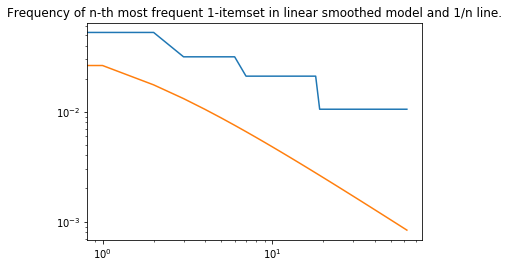

In [73]:
####****KEPT IN PHASE 4 TO PROVIDE COMPARISON IN EVALUATION TEXT GENERATION IN PHASE 5..
####****from phase 3 were we create new models of the language using the linear smoothing and weightings lambda
####****the linear smoothing quadgram model has minor error in indexing and should be updated.
#smoothing the ngramModel using a linear function of the kgrams for k = 1 to n
def ngramModel_LinearSmooth(inlist, n):
    #generate ngrams
    total = len(inlist)
    anoutcome = []
    for i in range(1,n+1):
        anoutcome.append(ngrams(inlist, i))
        #print("outcome: ")
        #print(anoutcome[i-1])
        
    #generate lamd coefficients for terms in model
    k = 1
    lamd = []
    last_lamd = 0
    for i in range(1,n):
        lamd.append(random.uniform(0,k))
        k = k-lamd[i -1]              
    lamd.append(k)
    print("lamd: ", lamd)
    #generate smooth model
    smooth_model = {}
    sumoflinearsmoothunimodel = 0
    for keyword in anoutcome[n-1]:
        grams = keyword.split(' ')
        #print("grams:")
        #print(grams)
        smooth_model.setdefault(keyword, lamd[0]*anoutcome[0][grams[0]]/total)
        for i in range(1,len(grams) - 2):
            sub_string = ' '.join(grams[0:i])
            sub_sub_string = ' '.join(input[0:i -1])
           # print(sub_string)
            smooth_model[keyword] = smooth_model[keyword] + lamd[i] * (anoutcome[i][sub_string]/anoutcome[i-1][keyword])
        #print(keyword + ":")
        #print(smooth_model[keyword])
        sumoflinearsmoothunimodel = sumoflinearsmoothunimodel + smooth_model[keyword]
    #print("smooth_model:")
    #print(smooth_model)
    print(f"the sum of the linear smoothed unigram model is {sumoflinearsmoothunimodel}")
    return smooth_model

linearsmoothunimodel = ngramModel_LinearSmooth(tokens, 1)

pandas.set_option("display.max_rows", 10)
linearsmoothunidataframe = pandas.DataFrame.from_dict(linearsmoothunimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Smoothed Unigram Prob. Model : ', len(linearsmoothunidataframe.index))
print(linearsmoothunidataframe)

#Attempt to plot the unigram language model using first a Counter object
COUNTLSMOOTH1 = Counter(linearsmoothunimodel)
greatestlinearsmoothprob1 = 0
biglinearsmoothword1 = ''
for w in COUNTLSMOOTH1.keys():
    if COUNTLSMOOTH1[w] >= greatestlinearsmoothprob1:
        biglinearsmoothword1 = w
        greatestlinearsmoothprob1 = COUNTLSMOOTH1[w]
        
print(f"the unigram of greatest freq in the smoothed unigram model is: {biglinearsmoothword1} \n")
MLS1 = COUNTLSMOOTH1[biglinearsmoothword1]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 1-itemset in linear smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLSMOOTH1.most_common()])
plot([(MLS1)/i for i in range(1, len(COUNTLSMOOTH1)+1)]);



In [74]:
### Now updating our linear smooth unigram model to include the test data...
#####*******update the model so that tokens that are in the test text not in the training
#####****** set have nonzero value...but something really small...use M = 1/(tot # in test + tot in training)
traintestlinearsmoothunimodel = linearsmoothunimodel
M = 0

for w in testtokens:
    M = M + 1
    if w not in linearsmoothunimodel.keys():
        traintestlinearsmoothunimodel.update({w: 0})       

for w in linearsmoothunimodel.keys():
    M = M + math.ceil(linearsmoothunimodel[w]*len(linearsmoothunimodel))

for w in traintestlinearsmoothunimodel.keys():
    if (traintestlinearsmoothunimodel[w] == 0):
        traintestlinearsmoothunimodel[w] = 1/M 
        
print('Number of rows in Linear Smooth Unigram Prob. Model w/o test data: ', len(linearsmoothunidataframe.index))        
print(linearsmoothunidataframe) 

traintestlinearsmoothunidataframe = pandas.DataFrame.from_dict(traintestlinearsmoothunimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Smooth Unigram Prob. Model w/ test data : ', len(traintestlinearsmoothunidataframe.index))
print(traintestlinearsmoothunidataframe)



Number of rows in Linear Smooth Unigram Prob. Model w/o test data:  63
           prob.
the     0.052632
cat     0.021053
named   0.010526
bob     0.021053
is      0.052632
...          ...
cats    0.010526
should  0.010526
not     0.010526
exist   0.010526
dogs    0.010526

[63 rows x 1 columns]
Number of rows in Linear Smooth Unigram Prob. Model w/ test data :  75
              prob.
the        0.052632
cat        0.021053
named      0.010526
bob        0.021053
is         0.052632
...             ...
sky        0.007692
blue       0.007692
today      0.007692
shadow     0.007692
yesterday  0.007692

[75 rows x 1 columns]


In [79]:
#####***** entropy calculation then perplexity for our linear smoothed unigram model of the test data:
####***** we will define our vocabulary to be all words in training + test set
####***** Then the idea is that entropy for the model, or likelyhood that the
####***** model would correctly predict the last word of a string of text in the form of test data
####***** is related to -(the sum over all unigrams in vocubulary x_i of prob(x_i)*log(prob(x_i))
TRAINTESTCOUNTLSMOOTH1 = Counter(traintestlinearsmoothunimodel)
vocproblinear = [COUNTLSMOOTH1[w] for w in COUNTLSMOOTH1.keys()]

entropysumlinear = 0
for prob in vocproblinear:
    entropysumlinear = entropysumlinear - (prob * math.log(prob, 2))
print("For our Linear Smoothed unigrammodel of the language:\n")
print("The number of bits we would need to find the correct last word of given phrase with \n")
print(f"the Linear Smoothed unigram model is the entropgy H = {entropysumlinear}")
perplexitylinear = (2**entropysumlinear)
print(f"The perplexity for the unigrammodel is 2^H = {perplexitylinear}")

For our Linear Smoothed unigrammodel of the language:

The number of bits we would need to find the correct last word of given phrase with 

the Linear Smoothed unigram model is the entropgy H = 5.75039801431027
The perplexity for the unigrammodel is 2^H = 53.83221989505292


The sum of all the unigram probabiities in the laplace smoothed model needs to be 1 and it is 0.9999999999999991
Number of rows in Laplace Smoothed Unigram Prob. Model :  63
           prob.
the     0.028169
cat     0.017606
named   0.014085
bob     0.017606
is      0.028169
...          ...
cats    0.014085
should  0.014085
not     0.014085
exist   0.014085
dogs    0.014085

[63 rows x 1 columns]
the unigram of greatest freq in the Laplace smoothed unigram model is: is 



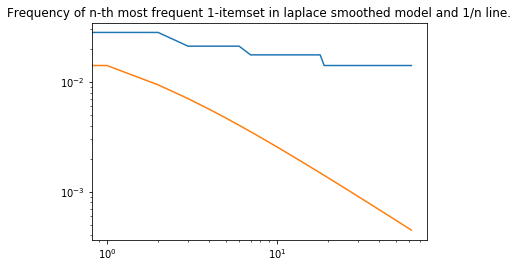

In [67]:
###****From Phase 3 of the project the Laplace smoothed unigram model
###****using the chosen training data test folder....relies on computation of the dataframes
###****per file
#Laplace smoothed unigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)

#Also left in the event we want to take into consideration of the file size when smoothing
#the language models... we created a Counter object for each file to seperate
#the unigramsin each file and their frequency in the file...
#the createListDoc_Foo_Counters below take in a list of strings, one fore each incoming file, which we
#created when we read in the files ....the smoothing in the Laplace smoothing below do not weight
#the files by size but do use these counters to tally up the total freqeuencies of ngrams and token count
def createListDocUniCounter(inlist):
    docfreqlist = []
    for i in range(len(inlist)):
        counter = Counter(newngram(inlist[i],1))
        docfreqlist.append(counter)
    return docfreqlist

dfforuniperfile = createListDocUniCounter(tokenfilelist)
firstunifile = dfforuniperfile[0]
#print(dfforuniperfile)
#print(firstunifile)

def createLeplaceSmoothedUnigramModel(outset, dfperfilelist):
    n = 1   
    anoutcome = ngrams(outset,n)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = anoutcome
    
    for w in laplaceprobmodel:
        laplaceprobmodel[w] = 0
  
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1
            
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
       
        
    #print(f"The laplaceprobmodel is \n {laplaceprobmodel}")
    print(f"The sum of all the unigram probabiities in the laplace smoothed model needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel    

laplacesmoothunimodel = createLeplaceSmoothedUnigramModel(tokens, dfforuniperfile)

pandas.set_option("display.max_rows", 10)
laplacesmoothunidf = pandas.DataFrame.from_dict(laplacesmoothunimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Unigram Prob. Model : ', len(laplacesmoothunidf.index))
print(laplacesmoothunidf)

#Attempt to plot the unigram language model using first a Counter object
COUNTLapSMOOTH1 = Counter(laplacesmoothunimodel)
greatestlaplacesmoothprob1 = 0
biglaplacesmoothword1 = ''
for w in COUNTLapSMOOTH1.keys():
    if COUNTLapSMOOTH1[w] >= greatestlaplacesmoothprob1:
        biglaplacesmoothword1 = w
        greatestlaplacesmoothprob1 = COUNTLapSMOOTH1[w]
        
print(f"the unigram of greatest freq in the Laplace smoothed unigram model is: {biglaplacesmoothword1} \n")
MLapS1 = COUNTLapSMOOTH1[biglaplacesmoothword1]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 1-itemset in laplace smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLapSMOOTH1.most_common()])
plot([(MLapS1)/i for i in range(1, len(COUNTLapSMOOTH1)+1)]);



In [78]:
### Now updating our laplace smooth unigram model to include the test data...
#####*******update the model so that tokens that are in the test text not in the training
#####****** set have nonzero value...but something really small...use M = 1/(tot # in test + tot in training)
traintestlaplacesmoothunimodel = laplacesmoothunimodel
M = 0

for w in testtokens:
    M = M + 1
    if w not in laplacesmoothunimodel.keys():
        traintestlaplacesmoothunimodel.update({w: 0})       

for w in laplacesmoothunimodel.keys():
    M = M + math.ceil(laplacesmoothunimodel[w]*len(laplacesmoothunimodel))

for w in traintestlaplacesmoothunimodel.keys():
    if (traintestlaplacesmoothunimodel[w] == 0):
        traintestlaplacesmoothunimodel[w] = 1/M 
        
print('Number of rows in Laplace Smooth Unigram Prob. Model w/o test data: ', len(laplacesmoothunidf.index))        
print(laplacesmoothunidf) 

traintestlaplacesmoothunidataframe = pandas.DataFrame.from_dict(traintestlaplacesmoothunimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smooth Unigram Prob. Model w/ test data : ', len(traintestlaplacesmoothunidataframe.index))
print(traintestlaplacesmoothunidataframe)



Number of rows in Laplace Smooth Unigram Prob. Model w/o test data:  63
           prob.
the     0.028169
cat     0.017606
named   0.014085
bob     0.017606
is      0.028169
...          ...
cats    0.014085
should  0.014085
not     0.014085
exist   0.014085
dogs    0.014085

[63 rows x 1 columns]
Number of rows in Laplace Smooth Unigram Prob. Model w/ test data :  75
              prob.
the        0.028169
cat        0.017606
named      0.014085
bob        0.017606
is         0.028169
...             ...
sky        0.005988
blue       0.005988
today      0.005988
shadow     0.005988
yesterday  0.005988

[75 rows x 1 columns]


In [80]:
#####***** entropy calculation then perplexity for our laplace smoothed unigram model of the test data:
####***** we will define our vocabulary to be all words in training + test set
####***** Then the idea is that entropy for the model, or likelyhood that the
####***** model would correctly predict the last word of a string of text in the form of test data
####***** is related to -(the sum over all unigrams in vocubulary x_i of prob(x_i)*log(prob(x_i))
TRAINTESTCOUNTLAPSMOOTH1 = Counter(traintestlaplacesmoothunimodel)
vocproblaplace = [TRAINTESTCOUNTLAPSMOOTH1[w] for w in TRAINTESTCOUNTLAPSMOOTH1.keys()]

entropysumlaplace = 0
for prob in vocproblaplace:
    entropysumlaplace = entropysumlaplace - (prob * math.log(prob, 2))
print("For our Laplace Smoothed unigrammodel of the language:\n")
print("The number of bits we would need to find the correct last word of given phrase with \n")
print(f"the Laplace Smoothed unigram model is the entropgy H = {entropysumlaplace}")
perplexitylaplace = (2**entropysumlaplace)
print(f"The perplexity for the laplace unigrammodel is 2^H = {perplexitylaplace}")

For our Laplace Smoothed unigrammodel of the language:

The number of bits we would need to find the correct last word of given phrase with 

the Laplace Smoothed unigram model is the entropgy H = 6.478359226595207
The perplexity for the laplace unigrammodel is 2^H = 89.16213309393059


In [ ]:
##### in an extension of the evaluation of the models, we could take the test data
####  break it into ngrams and peal off the last word.
####  for each of the ngrams we test and peal off the last word...generate a ranked set of next words, i.e.
####. our text generation method could be scaled to return not just one possible next word...but a ranked
####  list of next words...
####. this list of next words is a list of the predicted last word of the ngram from the test data...
####. how well did we do?  Is the correct last word of the actual ngram from the test data in the top 10%
####. of our returned list?  We have quantified that process above...but we leave the text generation 
####. modules here for that chance...
ranint = random.randint(0,len(laplacesmoothunimodel)-1)
print(ranint)

In [ ]:
####***** if you are feeling like generating a random seed for the text:
i = 0;
lapcounter = Counter(laplacesmoothunimodel)
ranint = random.randint(0, len(laplacesmoothunimodel)-1)
for w in laplacesmoothunimodel.keys():
    if (i == ranint):
        seedword = w
    i = i + 1
print(seedword)

####**** to set the seed to one of the most common 10 unigrams:
seedpossibilities = lapcounter.most_common(10)
ranint = random.randint(0,9)
seedtuple = seedpossibilities[ranint]
seedword = seedtuple[0]
print(seedword)

In [ ]:
#### from phase 2, The team kept both ngrams method and newngram method for computing the 
###unigrams, bigrams, trigrams and quadgrams smoothed models....
###output of newngram is a Counter obj and output of ngrams is a dictionary object...

#newngram outputs to files:
#the most common unigrams are set to unigramfile.dat
#the most common bigrams are set to bigramfile.dat
#the most common trigrams are set to trigramfile.dat
#the most common quadgrams are set to quadgramfile.dat

#!!!newngram again returns a Counter object 
def newngram(toks, n):
    output = {}   
    for i in range(len(toks) - n + 1):
        g = ' '.join(toks[i:i+n])
        output.setdefault(g, 0)
        output[g] += 1
    COUNTS = Counter(output)
    outputstring = ''
    outputstring = outputstring + str(COUNTS.most_common(3000)) + " "
    if n == 1:
        #print(f"\n   The most common unigrams are: {(COUNTS.most_common(10))}")
        f=open("unigramfile.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(3000))) #trying to keep file size at about 50 k for this sample
        outputstring = outputstring + str(COUNTS.most_common(3000)) + " "
        f.close()
    if n == 2:
        #print(f"\n   The most common bigrams are: {(COUNTS.most_common(10))}")
        f=open("bigramfile.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2700))) #trying to keep file size at about 50 k for this sample
        outputstring = outputstring + str(COUNTS.most_common(2700)) + " "
        f.close()
    if n == 3:
        #print(f"\n The most common trigrams are: {(COUNTS.most_common(10))}")
        f=open("trigramfile.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2300))) #trying to keep file size at about 50 k for this sample
        outputstring = outputstring + str(COUNTS.most_common(2300)) + " "
        f.close()
    if n == 4:
        #print(f"\n   The most common quadgrams are: {(COUNTS.most_common(10))}")
        f=open("quadgramfile.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2100))) #trying to keep file size at about 50 k for this sample
        outputstring = outputstring + str(COUNTS.most_common(2100)) + " "
        f.close()
    
    return output

###!!!! THESE COUNTS WILL BE USED IN THE TEXT GENERATION METHOD BELOW...THE PHASE 3 LAPLACE SMOOTH
###!!! MODELS ARE CREATED IMPLICITLY WITHIN THE GENERATING TEXT MODULE
newunigrams = newngram(tokens, 1)
print(unigrams)
newbigrams = newngram(tokens, 2)
#print(bigrams)
newtrigrams = newngram(tokens, 3)
#print(trigrams)
newquadgrams = newngram(tokens, 4)
#print(quadgrams)

####piecing together the development from when we posted the most common unigrams, bigrams
####trigrams and quadgrams to the files..now we are able to use them in this application 
####to generate text....

unigramfile="unigramfile.dat"
bigramfile="bigramfile.dat"
trigramfile="trigramfile.dat"
quadgramfile="quadgramfile.dat"

with open(unigramfile, 'rb', 0) as file, \
    mmap.mmap(file.fileno(), 0, access=mmap.ACCESS_READ) as text:
    unigramtotal= text.read(text.find(b'[')).decode('utf-8')
    unigrams= text.read(text.find(b']')).decode('utf-8')

with open(bigramfile, 'rb', 0) as file, \
    mmap.mmap(file.fileno(), 0, access=mmap.ACCESS_READ) as text:
    bigramtotal= text.read(text.find(b'[')).decode('utf-8')
    bigrams= text.read(text.find(b']')).decode('utf-8')

with open(trigramfile, 'rb', 0) as file, \
    mmap.mmap(file.fileno(), 0, access=mmap.ACCESS_READ) as text:
    trigramtotal= text.read(text.find(b'[')).decode('utf-8')
    trigrams= text.read(text.find(b']')).decode('utf-8')
    
with open(quadgramfile, 'rb', 0) as file, \
    mmap.mmap(file.fileno(), 0, access=mmap.ACCESS_READ) as text:
    quadgramtotal= text.read(text.find(b'[')).decode('utf-8')
    quadgrams= text.read(text.find(b']')).decode('utf-8')

words=unigrams.replace('[','').replace(']','').replace('(','').replace(')','').split(',')
unigramrange=0
for w in range(1,len(words)-1,2):
    unigramrange +=int(words[w])

In [ ]:
####****Finally Phase 4! Here is the geneartion method.  In the cell above,
####****you created a seedword for generating the text...either from the most frequent 10
####****unigramsstring or a random unigram...

def generate(seedtext, length):
    
    if length==0:
        output=''
    print("Scroll down for the final result.  Here is the process used:\n")
    for gword in range(1,length+1):
        if gword > 3:                     # use quadgram model

            
            print(f"Searching quadigrams for '{currenttrigram}'.")             
            quadgramoccurance = []
            quadgramoccurance.append(quadgrams.find("'" + currenttrigram + ' '))
            if quadgramoccurance[0] > -1:
                possiblequadgram = []
                possiblequadfrequency = []
                possiblequadtotalfreq = 0
                n = 0
                possiblequadgram.append(quadgrams[quadgramoccurance[n]+len(currenttrigram)+2:quadgrams.find("'",quadgramoccurance[n]+len(currenttrigram)+2)])
                try:
                    possiblequadfrequency.append(int(quadgrams[quadgrams.find("', ",quadgramoccurance[n])+3:quadgrams.find(")",quadgramoccurance[n])]))
                    possiblequadtotalfreq += possiblequadfrequency[n]
                except:
                    print("Error")
                n += 1
                while True:
                    quadgramoccurance.append(quadgrams.find("'" + currenttrigram + ' ', quadgramoccurance[n-1]+1))
    
                    if quadgramoccurance[n] == -1: break
                    possiblequadgram.append(quadgrams[quadgramoccurance[n]+len(currenttrigram)+2:quadgrams.find("'",quadgramoccurance[n]+len(currenttrigram)+2)])
                    try:
                        possiblequadfrequency.append(int(quadgrams[quadgrams.find("', ",quadgramoccurance[n])+3:quadgrams.find(")",quadgramoccurance[n])]))
                        possiblequadtotalfreq += possiblequadfrequency[n]
                    except:
                        print("Error")
                        break
                    n += 1
                rand=random.randint(0,possiblequadtotalfreq)
                look = rand
                for w in range(0,n):
                    look = look - possiblequadfrequency[w]
                    if look < 0:
                        nextword = possiblequadgram[w]
                        break
                print(f"        Out of {possiblequadtotalfreq} occurances in the quadgram model the following word:")
                for w in range(0,n):
                    print(f"          '{possiblequadgram[w]}' appeared {possiblequadfrequency[w]} times,")
                print(f"            From the {n} possibilities, we randomly chose '{nextword}'.")                             
            else:
                print(f"    Not found. Searching trigrams for '{currentbigram}'.")  
                trigramoccurance = []
                trigramoccurance.append(trigrams.find("'" + currentbigram + ' '))
                if trigramoccurance[0] > -1:
                    possibletrigram = []
                    possibletrifrequency = []
                    possibletritotalfreq = 0
                    n = 0
                    possibletrigram.append(trigrams[trigramoccurance[n]+len(currentbigram)+2:trigrams.find("'",trigramoccurance[n]+len(currentbigram)+2)])
                    try:
                        possibletrifrequency.append(int(trigrams[trigrams.find("', ",trigramoccurance[n])+3:trigrams.find(")",trigramoccurance[n])]))
                        possibletritotalfreq += possibletrifrequency[n]
                    except:
                        print("Error")
                    n += 1
                    while True:
                        trigramoccurance.append(trigrams.find("'" + currentbigram + ' ', trigramoccurance[n-1]+1))
                        if trigramoccurance[n] == -1: break
                        possibletrigram.append(trigrams[trigramoccurance[n]+len(currentbigram)+2:trigrams.find("'",trigramoccurance[n]+len(currentbigram)+2)])
                        try:
                            possibletrifrequency.append(int(trigrams[trigrams.find("', ",trigramoccurance[n])+3:trigrams.find(")",trigramoccurance[n])]))
                            possibletritotalfreq += possibletrifrequency[n]
                        except:
                            print("Error")
                            break
                        n += 1
                    rand=random.randint(0,possibletritotalfreq)
                    look = rand
                    for w in range(0,n):
                        look = look - possibletrifrequency[w]
                        if look < 0:
                            nextword = possibletrigram[w]
                            break
                    print(f"        Out of {possibletritotalfreq} occurances in the trigram model the following word:")
                    for w in range(0,n):
                        print(f"          '{possibletrigram[w]}' appeared {possibletrifrequency[w]} times,")
                    print(f"            From the {n} possibilities, we randomly chose '{nextword}'.")                             
                else:
                    print(f"        Not found. Searching bigrams for '{currentword}'.")        
                    bigramoccurance = []
                    bigramoccurance.append(bigrams.find("'" + currentword + ' '))
                    if bigramoccurance[0] > -1:
                        possiblebigram = []
                        possiblebifrequency = []
                        possiblebitotalfreq = 0
                        n = 0
                        possiblebigram.append(bigrams[bigramoccurance[n]+len(currentword)+2:bigrams.find("'",bigramoccurance[n]+len(currentword)+2)])
                        try:
                            possiblebifrequency.append(int(bigrams[bigrams.find("', ",bigramoccurance[n])+3:bigrams.find(")",bigramoccurance[n])]))
                            possiblebitotalfreq += possiblebifrequency[n]
                        except:
                            print("Error")
                        n += 1
                        while True:
                            bigramoccurance.append(bigrams.find("'" + currentword + ' ', bigramoccurance[n-1]+1))
                            nextword = bigrams[bigrams.find("'" + currentword + ' ')+len(currentword)+2:bigrams.find("'",bigrams.find(currentword + ' '))]
                            if bigramoccurance[n] == -1: break
                            possiblebigram.append(bigrams[bigramoccurance[n]+len(currentword)+2:bigrams.find("'",bigramoccurance[n]+len(currentword)+2)])
                            try:
                                possiblebifrequency.append(int(bigrams[bigrams.find("', ",bigramoccurance[n])+3:bigrams.find(")",bigramoccurance[n])]))
                                possiblebitotalfreq += possiblebifrequency[n]
                            except:
                                print("Error")
                                break
                            n += 1
                        rand=random.randint(0,possiblebitotalfreq)
                        look = rand
                        for w in range(0,n):
                            look = look - possiblebifrequency[w]
                            if look < 0:
                                nextword = possiblebigram[w]
                                break
                        print(f"          Out of {possiblebitotalfreq} occurances in the bigram model the following word:")
                        for w in range(0,n):
                            print(f"            '{possiblebigram[w]}' appeared {possiblebifrequency[w]} times,")
                        print(f"              From the {n} possibilities, we randomly chose '{nextword}'.")                
                    else:
                        rand=random.randint(0,unigramrange)
                        look = rand
                        for w in range(1,len(words)-1,2):
                            look = look - int(words[w])
                            if look < 0:
                                nextword = words[w-1][2:-1]
                                break
                        print(f"            Not found. We randomly choose '{nextword}'.")
            pastword =currentword
            currentword=nextword
            currentquadgram=currenttrigram + ' ' + currentword
            currenttrigram=currentbigram + ' ' + currentword
            currentbigram=pastword + ' ' + currentword
            output+=' ' + currentword 
            
            
        else:
            if gword == 3:                 # use trigram model
                print(f"      Searching trigrams for '{currentbigram}'.")        
                trigramoccurance = []
                trigramoccurance.append(trigrams.find("'" + currentbigram + ' '))
                if trigramoccurance[0] > -1:
                    possibletrigram = []
                    possibletrifrequency = []
                    possibletritotalfreq = 0
                    n = 0
                    possibletrigram.append(trigrams[trigramoccurance[n]+len(currentbigram)+2:trigrams.find("'",trigramoccurance[n]+len(currentbigram)+2)])
                    try:
                        possibletrifrequency.append(int(trigrams[trigrams.find("', ",trigramoccurance[n])+3:trigrams.find(")",trigramoccurance[n])]))
                        possibletritotalfreq += possibletrifrequency[n]
                    except:
                        print("Error")
                    n += 1
                    while True:
                        trigramoccurance.append(trigrams.find("'" + currentbigram + ' ', trigramoccurance[n-1]+1))
                        if trigramoccurance[n] == -1: break
                        possibletrigram.append(trigrams[trigramoccurance[n]+len(currentbigram)+2:trigrams.find("'",trigramoccurance[n]+len(currentbigram)+2)])
                        try:
                            possibletrifrequency.append(int(trigrams[trigrams.find("', ",trigramoccurance[n])+3:trigrams.find(")",trigramoccurance[n])]))
                            possibletritotalfreq += possibletrifrequency[n]
                        except:
                            print("Error")
                            break
                        n += 1
                    rand=random.randint(0,possibletritotalfreq)
                    look = rand
                    for w in range(0,n):
                        look = look - possibletrifrequency[w]
                        if look < 0:
                            nextword = possibletrigram[w]
                            break
                    print(f"        Out of {possibletritotalfreq} occurances in the trigram model the following word:")
                    for w in range(0,n):
                        print(f"          '{possibletrigram[w]}' appeared {possibletrifrequency[w]} times,")
                    print(f"            From the {n} possibilities, we randomly chose '{nextword}'.")                             
                else:
                    print(f"        Not found. Searching bigrams for '{currentword}'.")        
                    bigramoccurance = []
                    bigramoccurance.append(bigrams.find("'" + currentword + ' '))
                    if bigramoccurance[0] > -1:
                        possiblebigram = []
                        possiblebifrequency = []
                        possiblebitotalfreq = 0
                        n = 0
                        possiblebigram.append(bigrams[bigramoccurance[n]+len(currentword)+2:bigrams.find("'",bigramoccurance[n]+len(currentword)+2)])
                        try:
                            possiblebifrequency.append(int(bigrams[bigrams.find("', ",bigramoccurance[n])+3:bigrams.find(")",bigramoccurance[n])]))
                            possiblebitotalfreq += possiblebifrequency[n]
                        except:
                            print("Error")
                        n += 1
                        while True:
                            bigramoccurance.append(bigrams.find("'" + currentword + ' ', bigramoccurance[n-1]+1))
    
                            if bigramoccurance[n] == -1: break
                            possiblebigram.append(bigrams[bigramoccurance[n]+len(currentword)+2:bigrams.find("'",bigramoccurance[n]+len(currentword)+2)])
                            try:
                                possiblebifrequency.append(int(bigrams[bigrams.find("', ",bigramoccurance[n])+3:bigrams.find(")",bigramoccurance[n])]))
                                possiblebitotalfreq += possiblebifrequency[n]
                            except:
                                print("Error")
                                break
                            n += 1
                        rand=random.randint(0,possiblebitotalfreq)
                        look = rand
                        for w in range(0,n):
                            look = look - possiblebifrequency[w]
                            if look < 0:
                                nextword = possiblebigram[w]
                                break
                        print(f"          Out of {possiblebitotalfreq} occurances in the bigram model the following word:")
                        for w in range(0,n):
                            print(f"            '{possiblebigram[w]}' appeared {possiblebifrequency[w]} times,")
                        print(f"              From the {n} possibilities, we randomly chose '{nextword}'.")                
                    else:
                        rand=random.randint(0,unigramrange)
                        look = rand
                        for w in range(1,len(words)-1,2):
                            look = look - int(words[w])
                            if look < 0:
                                nextword = words[w-1][2:-1]
                                break
                        print(f"            Not found. We randomly choose '{nextword}'.")
                pastword =currentword
                currentword=nextword
                currenttrigram=currentbigram + ' ' + currentword
                currentbigram=pastword + ' ' + currentword
                output+=' ' + currentword 
            elif gword == 2:                 # use bigram model
                print(f"        Searching bigrams for '{currentword}'.")        
                bigramoccurance = []
                bigramoccurance.append(bigrams.find("'" + currentword + ' '))
                if bigramoccurance[0] > -1:
                    possiblebigram = []
                    possiblebifrequency = []
                    possiblebitotalfreq = 0
                    n = 0
                    possiblebigram.append(bigrams[bigramoccurance[n]+len(currentword)+2:bigrams.find("'",bigramoccurance[n]+len(currentword)+2)])
                    try:
                        possiblebifrequency.append(int(bigrams[bigrams.find("', ",bigramoccurance[n])+3:bigrams.find(")",bigramoccurance[n])]))
                        possiblebitotalfreq += possiblebifrequency[n]
                    except:
                        print("Error")
                    n += 1
                    while True:
                        bigramoccurance.append(bigrams.find("'" + currentword + ' ', bigramoccurance[n-1]+1))
                        if bigramoccurance[n] == -1: break
                        possiblebigram.append(bigrams[bigramoccurance[n]+len(currentword)+2:bigrams.find("'",bigramoccurance[n]+len(currentword)+2)])
                        try:
                            possiblebifrequency.append(int(bigrams[bigrams.find("', ",bigramoccurance[n])+3:bigrams.find(")",bigramoccurance[n])]))
                            possiblebitotalfreq += possiblebifrequency[n]
                        except:
                            print("Error")
                            break
                        n += 1
                    rand=random.randint(0,possiblebitotalfreq)
                    look = rand
                    for w in range(0,n):
                        look = look - possiblebifrequency[w]
                        if look < 0:
                            nextword = possiblebigram[w]
                            break
                    print(f"          Out of {possiblebitotalfreq} occurances in the bigram model the following word:")
                    for w in range(0,n):
                        print(f"            '{possiblebigram[w]}' appeared {possiblebifrequency[w]} times,")
                    print(f"              From the {n} possibilities, we randomly chose '{nextword}'.")                
                else:
                    rand=random.randint(0,unigramrange)
                    look = rand
                    for w in range(1,len(words)-1,2):
                        look = look - int(words[w])
                        if look < 0:
                            nextword = words[w-1][2:-1]
                            break
                    print(f"            Not found. We randomly choose '{nextword}'.")
                pastword =currentword
                currentword=nextword
                currentbigram=pastword + ' ' + currentword
                output+=' ' + currentword

            elif gword == 1:                     # check seedtext
                for char in range(0,len(seedtext)):
                    maybe = seedtext[:len(seedtext)-char]
                    print(f"          Searching unigrams for '{maybe}'.")        
                    if unigrams.find(maybe) > -1:
                        if unigrams[unigrams.find(maybe)-1] == "'":
                            print("            Found the word (or a word that starts with it).")
                            currentword = unigrams[unigrams.find(maybe):unigrams.find("'",unigrams.find(maybe))]
                            break
                    print("            Not found. Dropping a letter")
                    currentword = ""           
                if currentword == "":
                    rand=random.randint(0,unigramrange)
                    look = rand
                    for w in range(1,len(words)-1,2):
                        look = look - int(words[w])
                        if look < 0:
                            currentword = words[w-1][2:-1]    
                            break
                    print(f"              We randomly choose '{currentword}'.")
                output=currentword
    
    print(f"\n\n     Given '{seedtext}', our initial model generates the following {length} words:\n\n{output.replace(' .','.')}")


In [ ]:
generate(seedword, 100)